### Capstone 3. Waste Classification

In [ ]:
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daongandmimi","key":"13ecbf24f8d3867b9ac53b482e2529e4"}'}

In [ ]:
ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 방지
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d techsash/waste-classification-data

100% 427M/427M [00:19<00:00, 23.5MB/s]
100% 427M/427M [00:19<00:00, 23.0MB/s]


In [ ]:
!!unzip -qq "/content/waste-classification-data.zip"

[]

 #### <span>Import Libraries</span>

In [ ]:
import numpy as np    # 선형 대수 지원 라이브러리
import pandas as pd   # 데이터 처리, CSV 파일 I/O(예: pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from keras.callbacks import ReduceLROnPlateau # pip install callbacks
import cv2 # pip install opencv-python
import os

import tensorflow as tf 
import tqdm
import random

In [ ]:
labels = ['O', 'R']
img_size = 150
def get_training_data(data_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

### <span style="color:#BF1E96">Dataset 불러오기</span>

In [ ]:
train = get_training_data('/content/DATASET/TRAIN')
test = get_training_data('/content/DATASET/TEST')

<ipython-input-7-43a741b2fb12>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


### <span style="color:#BF1E96">데이터 시각화</span>

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


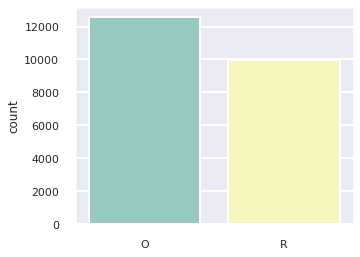

In [ ]:
l = []
for i in train:
    if(i[1] == 0):
        l.append("O")
    else:
        l.append("R")
        
plt.figure(figsize=(5,4))
sns.set_style('darkgrid')
sns.set_context("poster", font_scale = .5, rc={"grid.linewidth": 2})
sns.countplot(l, palette='Set3')   

### <span style="color:#BF1E96">데이터 전처리</span>

#### 이미지 확인

Text(0.5, 1.0, 'R')

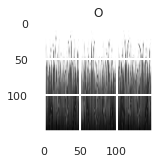

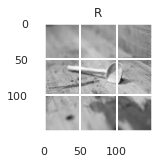

In [ ]:
plt.figure(figsize = (2,2))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (2,2))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [ ]:
x_train = []
y_train = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

#### 데이터 정규화

In [ ]:
x_train = np.array(x_train) / 255
x_test = np.array(x_test) / 255

#### 이미지 크기 조정

In [ ]:
x_train = x_train.reshape(-1, img_size, img_size, 1) # (None,224,224,1) 형태로 reshape
y_train = np.array(y_train)

x_test = x_test.reshape(-1, img_size, img_size, 1) # (None,224,224,1) 형태로 reshape
y_test = np.array(y_test)

#### 훈련 데이터 이미지 개수 확인

In [ ]:
print("Num training images: ", len(train))

Num training images:  22564


In [ ]:
train_c_dir = '/content/DATASET/TRAIN/O'
train_uc_dir = '/content/DATASET/TRAIN/R'

def get_files_count(folder_path):
    dirListing = os.listdir(folder_path)
    return len(dirListing)

print("organic images count:", get_files_count(train_c_dir))
print("recyclable images count:", get_files_count(train_uc_dir))


organic images count: 12565
recyclable images count: 9999


### <span style="color:#BF1E96">과적합 방지를 위해 데이터 확대</span>

In [ ]:
# 과적합을 방지하고 데이터 세트의 불균형을 처리하기 위한 데이터 확대

datagen = ImageDataGenerator(
        featurewise_center=False,              # 데이터셋에 대해 입력 평균을 0으로 설정
        samplewise_center=False,               # 각 샘플 평균을 0으로 설정
        featurewise_std_normalization=False,   # 데이터 세트의 표준으로 입력 나눕니다.
        samplewise_std_normalization=False,    # 각 입력을 std로 나눕니다.
        width_shift_range=0.1,                 # 이미지를 가로로 무작위로 이동(전체 너비의 일부)
        height_shift_range=0.1) 


datagen.fit(x_train)

### <span style="color:#BF1E96">모델 훈련</span>

훈련 데이터(X_train, y_train)로 선언한 Sequential 모델(변수명 model)을 이용하여 학습(fit)하고 학습 과정을 histroy 에 저장하기

In [ ]:
model = Sequential() #Seqeuntial모델 오브젝트

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (150,150,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))



- 모델 확인

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      320       
                                                                 
 batch_normalization (BatchN  (None, 150, 150, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 75, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 dropout (Dropout)           (None, 75, 75, 64)        0         
                                                                 
 batch_normalization_1 (Batc  (None, 75, 75, 64)       2

- 모델 컴파일

In [ ]:
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])

- 학습률 조정(ReduceLROnPlateau)

In [ ]:
learning_rate_reduction = ReduceLROnPlateau(monitor='accuracy', patience = 3, verbose=1,factor=0.3, min_lr=0.001)

- 모델 학습, 학습 과정 histroy변수에 저장

In [ ]:
hist = model.fit(datagen.flow(x_train,y_train, batch_size = 24) ,epochs = 12 ,callbacks = [learning_rate_reduction])

Epoch 1/12
941/941 [==============================] - 66s 57ms/step - loss: 0.6219 - accuracy: 0.7273 - lr: 0.0010
Epoch 2/12
941/941 [==============================] - 44s 47ms/step - loss: 0.4950 - accuracy: 0.7854 - lr: 0.0010
Epoch 3/12
941/941 [==============================] - 45s 48ms/step - loss: 0.4562 - accuracy: 0.8061 - lr: 0.0010
Epoch 4/12
941/941 [==============================] - 44s 46ms/step - loss: 0.4364 - accuracy: 0.8175 - lr: 0.0010
Epoch 5/12
941/941 [==============================] - 44s 46ms/step - loss: 0.4225 - accuracy: 0.8252 - lr: 0.0010
Epoch 6/12
941/941 [==============================] - 44s 46ms/step - loss: 0.4107 - accuracy: 0.8291 - lr: 0.0010
Epoch 7/12
941/941 [==============================] - 45s 48ms/step - loss: 0.3977 - accuracy: 0.8388 - lr: 0.0010
Epoch 8/12
941/941 [==============================] - 43s 46ms/step - loss: 0.3873 - accuracy: 0.8403 - lr: 0.0010
Epoch 9/12
941/941 [==============================] - 43s 46ms/step - loss: 0.38

<Figure size 360x288 with 0 Axes>

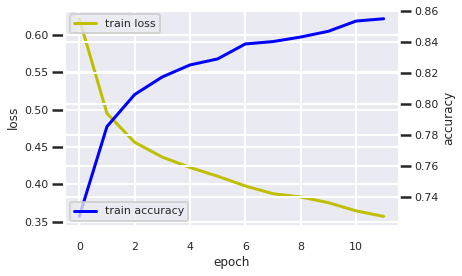

In [ ]:
# 모델 학습과정 표시하기
import matplotlib.pyplot as plt

plt.figure(figsize=(5,4))
fig, loss_ax = plt.subplots()
acc_ax = loss_ax.twinx()

loss_ax.plot(hist.history['loss'], 'y', label = 'train loss')

acc_ax.plot(hist.history['accuracy'], 'b', label = 'train accuracy')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc = 'upper left')
acc_ax.legend(loc = 'lower left')

plt.show()

- 학습에서 얻은 모델을 test데이터로 평가

In [ ]:
print("Loss of the model is - " , model.evaluate(x_test,y_test, verbose=2)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test, verbose=2)[1]*100 , "%")

79/79 - 2s - loss: 0.4814 - accuracy: 0.7859 - 2s/epoch - 20ms/step
Loss of the model is -  0.48141369223594666
79/79 - 1s - loss: 0.4814 - accuracy: 0.7859 - 853ms/epoch - 11ms/step
Accuracy of the model is -  78.59132289886475 %


### <span style="color:#BF1E96">훈련된 모델 분석</span>

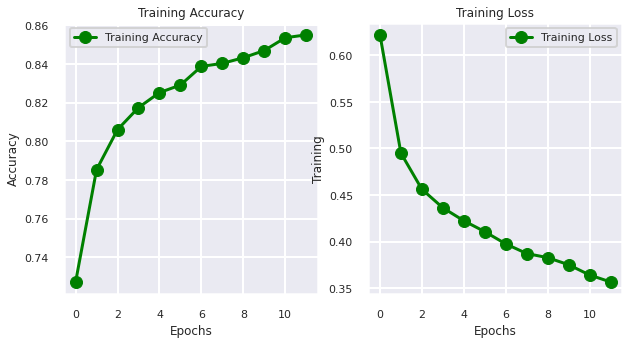

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = hist.history['accuracy']
train_loss = hist.history['loss']

fig.set_size_inches(10,5)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].set_title('Training Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs") 
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].set_title('Training Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training")
plt.show()

In [ ]:
predicted = (model.predict(x_test) > 0.5).astype("int32")
predictions = predicted.reshape(1,-1)[0]

predictions[:15]


79/79 [==============================] - 1s 12ms/step


array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0], dtype=int32)

In [ ]:
print(classification_report(y_test, predictions, target_names = ['organic (Class 0)','recyclable (Class 1)']))

                      precision    recall  f1-score   support

   organic (Class 0)       0.92      0.68      0.78      1401
recyclable (Class 1)       0.69      0.92      0.79      1112

            accuracy                           0.79      2513
           macro avg       0.81      0.80      0.79      2513
        weighted avg       0.82      0.79      0.78      2513



In [ ]:
cm = confusion_matrix(y_test,predictions)
cm

array([[ 947,  454],
       [  84, 1028]])

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

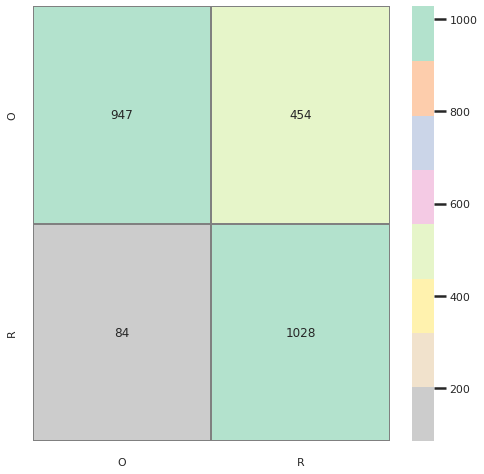

In [ ]:
plt.figure(figsize = (8,8))
sns.heatmap(cm,cmap= "Pastel2_r", linecolor = 'gray' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

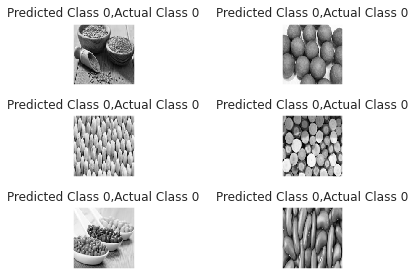

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

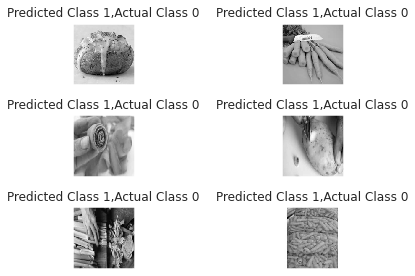

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(150,150), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

### <span style="color:#BF1E96">Sample Data</span>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = "/content/drive/MyDrive/OR/OR"
#path = os.path.join(data_dir)
img_size = 150
def get_sampling_data(data_dir):
    data = []
    for img in os.listdir(path):
        try:
            img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
            resized_arr = cv2.resize(img_arr, (img_size, img_size)) # 원하는 크기로 이미지 크기 변경
            data.append(resized_arr)
        except Exception as e:
            print(e)
    return np.array(data)

In [ ]:
sample = get_sampling_data(path)

In [ ]:
sample = np.array(sample) / 255

In [ ]:
sample = sample.reshape(-1, img_size, img_size, 1) # (None,224,224,1) 형태로 reshape

In [ ]:
predicted_S = (model.predict(sample) > 0.5).astype("int32")
predictions_sample = predicted_S.reshape(1,-1)[0]

predictions_sample[:15]

4/4 [==============================] - 0s 56ms/step


array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0], dtype=int32)

In [ ]:
final_score = 0
for i in range(len(predictions_sample)):
    if i <50:
        if predictions_sample[i] == 0:
            final_score += 1
    else:
        if predictions_sample[i] == 1:
            final_score += 1
print(final_score)

67


In [ ]:
predictions_sample

array([1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)